## 1. Create a Image Hash.

### Idea from https://github.com/mendesk/image-ndd-lsh

In [1]:
!python3 -m pip install imagehash Image

In [2]:
import imagehash
from PIL import Image
import numpy as np

Article -> https://pypi.org/project/ImageHash/
dhash -> difference hash

In [3]:
def calculate_signature(image_file: str, hash_size: int) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

In [43]:
def calculate_signature_np(image_file: np.array, hash_size: int) -> np.ndarray:
    pil_image = Image.fromarray(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

## 2. Create LSH algorithm

### 2.1 Get the dataset

In [44]:
#!apt-get install wget
#!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [45]:
#!tar -xvzf cifar-10-python.tar.gz

In [46]:
#!rm -rf cifar-10-python.tar.gz
#!mv cifar-10-batches-py ../data

### 2.2 Read the files

In [47]:
import os
import _pickle as cPickle

In [48]:
PATH = "../data/cifar-10-batches-py/"

#### 2.2.1 Load Cifar-10

In [49]:
def load_batch():
    file = 'data_batch_1'

    f = open(PATH+file, 'rb')
    dict = cPickle.load(f, encoding='latin1')
    images = dict['data']
    #images = np.reshape(images, (10000, 3, 32, 32))
    labels = dict['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

In [50]:
def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

def print_classes(label_names):
    for i in range(0, 10):
        print(str(i) + " : " + label_names[i] + "  ")

label_names = load_classes()
print_classes(label_names)

0 : airplane  
1 : automobile  
2 : bird  
3 : cat  
4 : deer  
5 : dog  
6 : frog  
7 : horse  
8 : ship  
9 : truck  


In [51]:
images, labels = load_batch()

In [52]:
labels.shape

(10000,)

In [53]:
image = np.reshape(images[0], (3, 32, 32))

In [54]:
image.shape

(3, 32, 32)

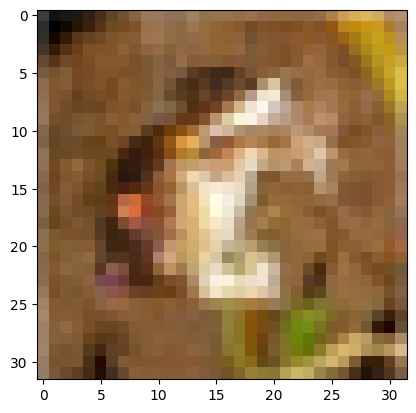

In [55]:
from matplotlib import pyplot as plt
plt.imshow(image.T, interpolation='nearest')
plt.show()

In [56]:
print(label_names[labels[0]])

frog


In [57]:
calculate_signature_np(image.T, 8)

array([ True,  True,  True, False, False,  True,  True,  True, False,
        True, False, False,  True, False, False,  True, False, False,
        True,  True,  True, False, False, False, False, False,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False, False, False,  True, False, False,  True,  True, False,
       False,  True, False, False, False,  True,  True, False, False,
        True, False, False,  True,  True, False, False,  True, False,
       False])

### 2.2.2 Algorithm

In [58]:
from typing import List, Dict, Tuple

class LSH:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):  # shingels
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0;
        for image in images:
            signature = calculate_signature_np(image.T, self.hash_size)
            self.signatures[idx] = np.packbits(signature.astype(np.uint8))
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates
            
    

In [59]:
images = images.reshape(10000,3,32,32)
images.shape

(10000, 3, 32, 32)

In [60]:
import time


lsh = LSH(8, 8)

start = time.time()
shingels = lsh.compute_hash(images)
print( "time: ", time.time() - start )

start = time.time()
pairs = lsh.compute_candidate()
print( "time: ", time.time() - start )

start = time.time()
duplicates = lsh.check_candidate(pairs,0.85)
print( "time: ", time.time() - start )

time:  0.9261500835418701
time:  1.087817907333374
time:  25.467944622039795


In [62]:
print(len(pairs))
print(len(lsh.buckets))

1967116
8


In [84]:
lsh = LSH(16, 8)

start = time.time()
shingels = lsh.compute_hash(images)
print( "time: ", time.time() - start )

start = time.time()
pairs = lsh.compute_candidate()
print( "time: ", time.time() - start )

start = time.time()
duplicates = lsh.check_candidate(pairs,0.80)
print( "time: ", time.time() - start )

print(len(pairs))
print(len(lsh.buckets))

time:  1.0281763076782227
time:  20.46225070953369
time:  461.7196252346039
32065325
16


0


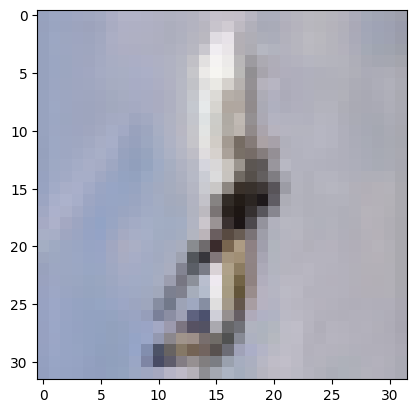

In [78]:
print(labels[264])
plt.imshow(images[264].reshape(3,32,32).T, interpolation='nearest')
plt.show()

0


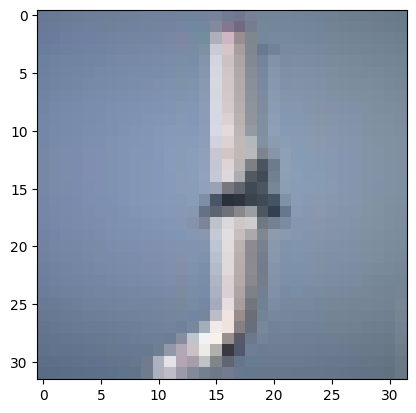

In [79]:
print(labels[7663])
plt.imshow(images[7663].reshape(3,32,32).T, interpolation='nearest')
plt.show()

dhash is a Python library that generates a "difference hash" for a given image -- 
a perceptual hash based on Neal Krawetz's dHash algorithm in this "Hacker Factor" blog entry.

I've found that dhash is great for detecting near duplicates (we found dupes using a size 8 dhash with a maximum delta of 2 bits). But because of the simplicity of the algorithm, it's not great at finding similar images or duplicate-but-cropped images -- you'd need a more sophisticated image fingerprint if you want that. However, the dhash is good for finding exact duplicates and near duplicates, for example, the same image with slightly altered lighting, a few pixels of cropping, or very light photoshopping.

The library defaults to producing a size 8 dhash, but you can override this easily by passing size=N as a keyword argument to most functions. For example, you can produce a more accurate (but slower to work with) dhash of 512 bits by specifying size=16.


### LSH with MinHash POC

In [65]:
def build_vocab(hash_size):
    vocab = []
    for i in range(hash_size**2):
        vocab.append(i)
    return vocab

In [66]:
import random 
def create_minhash_hashlists(vocab_size: int, n=20):
  hashlist = []
  for i in range(n):
    arr = list(range(1, vocab_size+1))
    random.shuffle(arr)
    hashlist.append(arr.copy())
  return hashlist

In [67]:
def minhash_gpu(onehots: np.array, hashlists, bs=50):
    h = np.array(hashlists)
    sigidx = np.zeros((h.shape[0], onehots.shape[0]))

    # fix zeros on arr resulting in 0 after multiplication
    n = onehots.shape[0]
    t_h = torch.from_numpy(h).cuda()
    for i in range(0, onehots.shape[0], bs):
        s = slice(i, min(i+bs, n))
        t_onehots = torch.from_numpy(onehots[s]).cuda()

        arr = torch.einsum('ij,kj->ikj', t_h, t_onehots)
        arr[arr == 0] = 2**63-1
        # sigidx is uniformally distributed, thereby used as hash
        sigidx[:,s] = arr.argmin(axis=2).cpu()

    return sigidx

In [68]:
vocab = build_vocab(16)
len(vocab)

256

In [69]:
hashlists = create_minhash_hashlists(len(vocab))
len(hashlists)

20

In [70]:
def gethot(tokens, vocab):
    return [1 if x in tokens else 0 for x in vocab]

In [71]:
print( len(shingels) )
print( shingels[0].shape )
print( shingels[0] )

10000
(8,)
[231  73  56  48 113  50  50 100]


In [33]:
a1hot = gethot(shingels[0], vocab)
b1hot = gethot(shingels[1], vocab)
c1hot = gethot(shingels[2], vocab)
d1hot = gethot(shingels[5119], vocab)
e1hot = gethot(shingels[9967], vocab)

In [34]:
import torch

In [35]:
print( len(a1hot) )
print( len([a1hot, b1hot, c1hot,d1hot,e1hot]) )
print( np.array([a1hot, b1hot, c1hot,d1hot,e1hot]).shape )
sigs = minhash_gpu(np.array([a1hot, b1hot, c1hot,d1hot,e1hot]), hashlists)

256
5
(5, 256)


In [36]:
def unstack(a, axis=0):
  return np.moveaxis(a, axis, 0)

In [37]:
print(sigs.shape)
print(sigs)

(20, 5)
[[231.  50.  23. 111. 111.]
 [ 50. 240.  23. 112. 112.]
 [ 48.  48.  23. 111. 111.]
 [ 50.  50.  23. 120. 248.]
 [ 48.  48. 129.  60. 111.]
 [113. 241. 129. 111. 111.]
 [ 56.  50. 129.  63. 108.]
 [231.  51.   3. 110. 108.]
 [201. 240.   3.  46.  62.]
 [ 48.  48.   3. 111. 248.]
 [ 50.  50.  23.  60. 248.]
 [ 48.  48. 129.  51. 248.]
 [231. 121. 131. 111. 111.]
 [113.  48.   3.  60.  55.]
 [ 50. 121. 131. 120. 248.]
 [231. 241.   3.  46. 108.]
 [ 50.  50.   3.  51.  55.]
 [201. 240. 131. 111.  62.]
 [201. 121. 131. 111. 111.]
 [231. 241. 131. 110. 108.]]


In [38]:
asig, bsig, csig, dsig, esig = unstack(sigs, axis=1)

In [39]:
print(esig)
print(asig) 

[111. 112. 111. 248. 111. 111. 108. 108.  62. 248. 248. 248. 111.  55.
 248. 108.  55.  62. 111. 108.]
[231.  50.  48.  50.  48. 113.  56. 231. 201.  48.  50.  48. 231. 113.
  50. 231.  50. 201. 201. 231.]


In [40]:
from itertools import combinations

class LSH2:
    def __init__(self, b):
        self.b = b
        # buckets maps between matching sig fragments and IDs
        # A whole list should be inserted as-is so its indexes match the bucket IDs
        self.buckets = []
        self.counter = 0
        for i in range(b):
            self.buckets.append({})

    def add_hashes(self, sigs):
        if isinstance(sigs, list):
            sigs = np.array(sigs).T

        subvecs = self.split_vec(sigs).astype('str')
        tmp = np.char.add(subvecs[:,0], ',')
        subvecs = np.char.add(tmp, subvecs[:,1])
        for sig_subvecs in subvecs.T:
            for i, subvec in enumerate(sig_subvecs):
                if subvec not in self.buckets[i].keys():
                    self.buckets[i][subvec] = []
                self.buckets[i][subvec].append(self.counter)
            self.counter += 1

    def split_vec(self, sigs):
        if isinstance(sigs, list):
            sigs = np.array(sigs).T

        sig_len, sigs_num = np.shape(sigs)
        assert(self.b < sig_len)
        assert((np.any(sig_len % self.b) != 0) == False)

        return np.array(np.array_split(sigs, self.b, axis=0))

    def check_candidates(self):
        candidates = []
        print(len(self.buckets))
        for band in self.buckets:
            for keys, hits in band.items():
                if len(hits) > 1:
                    candidates.extend(combinations(hits, 2))

        return set(candidates)

lsh2 = LSH2(5)
lsh2.add_hashes([asig,asig, bsig, csig, dsig, esig])
lsh2.buckets

[{'231.0,50.0': [0, 1],
  '50.0,240.0': [2],
  '23.0,23.0': [3],
  '111.0,112.0': [4, 5]},
 {'48.0,113.0': [0, 1],
  '48.0,241.0': [2],
  '129.0,129.0': [3],
  '60.0,111.0': [4],
  '111.0,111.0': [5]},
 {'201.0,48.0': [0, 1],
  '240.0,48.0': [2],
  '3.0,3.0': [3],
  '46.0,111.0': [4],
  '62.0,248.0': [5]},
 {'231.0,113.0': [0, 1],
  '121.0,48.0': [2],
  '131.0,3.0': [3],
  '111.0,60.0': [4],
  '111.0,55.0': [5]},
 {'50.0,201.0': [0, 1],
  '50.0,240.0': [2],
  '3.0,131.0': [3],
  '51.0,111.0': [4],
  '55.0,62.0': [5]}]

In [41]:
candidates2 = list(lsh2.check_candidates())
print(candidates2)

5
[(0, 1), (4, 5)]


#### Prepare images

In [42]:
import time

start = time.time()

lsh = LSH(16, 16)
shingels = lsh.compute_hash(images)

vocab = build_vocab(16)
hashlists = create_minhash_hashlists(len(vocab), 40)

n_hots = []
for i in range (0, len(shingels)):
    n_hots.append(gethot(shingels[i], vocab))

print(np.array(n_hots).shape)
sigs = minhash_gpu(np.array(n_hots), hashlists)
#sigs2 = np.moveaxis(sigs, 1, 0)

lsh2 = LSH2(5)
lsh2.add_hashes(sigs)

candidate_pairs = list(lsh2.check_candidates())
print(len(candidate_pairs))
end = time.time()
print( "time: ", end - start )

(10000, 256)
5
1762797
time:  11.587964057922363


In [43]:
print(candidate_pairs[0:100])

[(2057, 4668), (27, 1972), (3943, 4232), (3404, 3924), (4522, 7292), (594, 2019), (1373, 8173), (7128, 8643), (991, 4873), (2183, 7224), (6216, 9315), (4134, 6429), (8461, 9721), (8158, 9912), (925, 6505), (6651, 9243), (5533, 5875), (1801, 3924), (4841, 8765), (7563, 8571), (641, 1084), (9028, 9768), (5842, 6630), (2082, 3385), (1889, 9406), (7742, 7755), (617, 5571), (4688, 4736), (1553, 3795), (2812, 5890), (3401, 9668), (3903, 4402), (2504, 4956), (7206, 7371), (3749, 3935), (695, 916), (4146, 6789), (601, 1254), (1129, 7789), (152, 3148), (6996, 9254), (807, 5294), (3052, 5700), (218, 4899), (2515, 5495), (1962, 7009), (1243, 1660), (4427, 9633), (1463, 3878), (5289, 8874), (3259, 6178), (1089, 1193), (4700, 8479), (588, 2897), (4967, 6379), (1987, 2343), (1706, 6265), (152, 9914), (59, 3307), (2361, 8411), (854, 7742), (6432, 7576), (7278, 8536), (1397, 8893), (7653, 7659), (2039, 5916), (213, 7157), (1010, 1085), (7639, 9481), (7587, 9291), (4196, 4223), (3480, 8217), (522, 7912

In [44]:
#lsh2.buckets

0


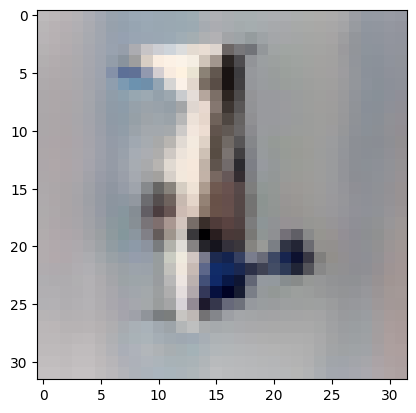

In [45]:
print(labels[2403])
plt.imshow(images[2403].reshape(3,32,32).T, interpolation='nearest')
plt.show()

7


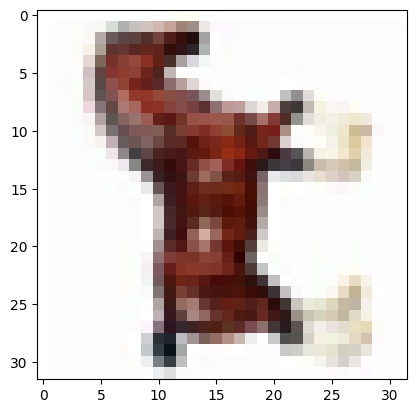

In [46]:
print(labels[6059])
plt.imshow(images[6059].reshape(3,32,32).T, interpolation='nearest')
plt.show()

In [47]:
!pip install scikit-learn
!pip install pandas

In [48]:
fig = plt.figure()
plt.imshow(grad, cmap='gray')

NameError: name 'grad' is not defined

<Figure size 640x480 with 0 Axes>

In [49]:
import torch 
import torchvision

def convolve(img, weights, hash_size, padding_size = 0):
    tensor_image = torch.reshape(img,(1,1,hash_size, hash_size))
    conv_img = torch.nn.functional.conv2d(tensor_image, weights, padding=int(padding_size))
    conv_img = conv_img.squeeze(0)
    conv_img = torch.permute(conv_img, (1,2,0))
    return conv_img

def gauss_kernel(size, sig=1.):
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    res = kernel / np.sum(kernel)
    return torch.DoubleTensor(res.reshape(1,1,size,size))

def sobel_filters(img):
    
    Kx = torch.DoubleTensor([[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]])
    Ky = torch.DoubleTensor([[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]])
    
    img = img.unsqueeze(0)
    img = torch.permute(img, (0,3,1,2))

    Ix = torch.nn.functional.conv2d(img, Kx.unsqueeze(0))
    Iy = torch.nn.functional.conv2d(img, Ky.unsqueeze(0))
    
    return Ix, Iy

def relu(grad, _min):
    return torch.where(grad > _min, grad, 0.)

def calculate_signature_np_only_edges(image_file: np.array, hash_size: int):
    pil_image = Image.fromarray(image_file).convert("L")

    size = 5
    kernel = gauss_kernel(size)
    origin_image_size = 32

    np_image = np.array(pil_image).astype(np.float64)
    tensor_image = torch.tensor(np_image)

    image_blurred = convolve(tensor_image, kernel, origin_image_size, int(np.sqrt(size)))

    sobels = sobel_filters(image_blurred)
    gradient = np.sqrt(sobels[0]**2 + sobels[1]**2) 

    grad = relu(gradient, 0.5)
    grad = grad.squeeze(0)
    
    pil_image = torchvision.transforms.functional.to_pil_image(grad.to(torch.int32))
    pil_image.resize((hash_size+1, hash_size),Image.BILINEAR)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()

    return signature
    #return pil_image
    #return grad


In [53]:
def calculate_signature_np_only_edges_with_all_return(image_file: np.array, hash_size: int):
    pil_image = Image.fromarray(image_file).convert("L")

    size = 5
    kernel = gauss_kernel(size)
    origin_image_size = 32

    np_image = np.array(pil_image).astype(np.float64)
    tensor_image = torch.tensor(np_image)

    image_blurred = convolve(tensor_image, kernel, origin_image_size, int(np.sqrt(size)))

    sobels = sobel_filters(image_blurred)
    gradient = np.sqrt(sobels[0]**2 + sobels[1]**2) 

    grad = relu(gradient, 0.5)
    grad = grad.squeeze(0)
    
    pil_image = torchvision.transforms.functional.to_pil_image(grad.to(torch.int32))
    pil_image.resize((hash_size+1, hash_size),Image.BILINEAR)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()

    return signature, image_blurred, sobels[0], sobels[1]
    #return pil_image
    #return grad


In [54]:
img_hash = calculate_signature_np_only_edges(images[5834].T, 32)
img_hash

array([False, False, False, ..., False,  True,  True])

In [61]:
img_hash2, imgBlurred, sobel1, sobels2 = calculate_signature_np_only_edges_with_all_return(images[256].T, 32)

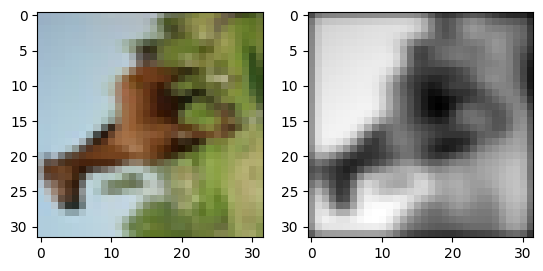

In [73]:
fig, axes = plt.subplots(1, 2)
ax = axes[0]
ax.imshow(images[256].T)

ax = axes[1]
ax.imshow(imgBlurred, cmap="gray")
plt.savefig("GaussianBlur.jpg")

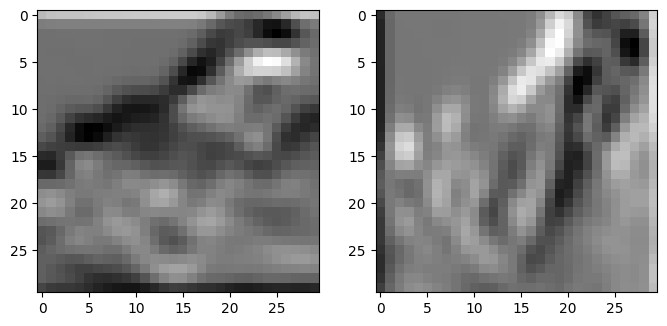

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(8,6))
ax = axes[0]
ax.imshow(sobel1[0].T, cmap="gray")

ax = axes[1]
ax.imshow(sobels2[0].T, cmap="gray")
plt.savefig("SobelsGradients.jpg")

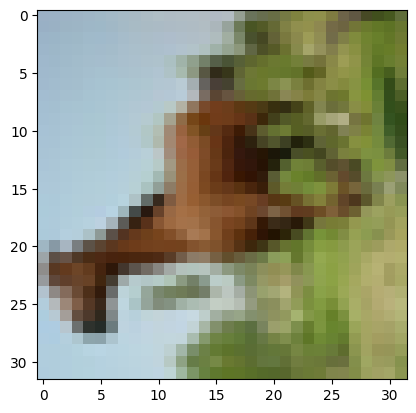

In [63]:
fig = plt.figure()
plt.imshow(images[256].T, cmap='gray')

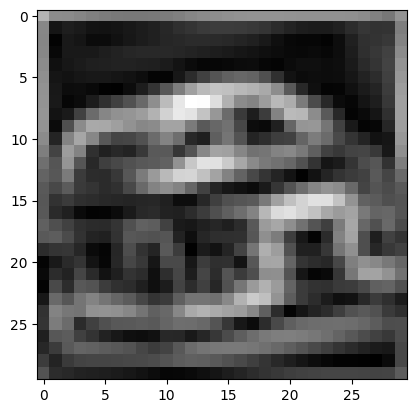

In [280]:
fig = plt.figure()
plt.imshow(img_hash.T, cmap='gray')

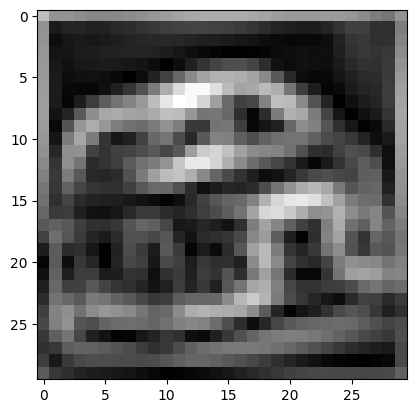

In [282]:
fig = plt.figure()
plt.imshow(img_hash.T, cmap='gray')

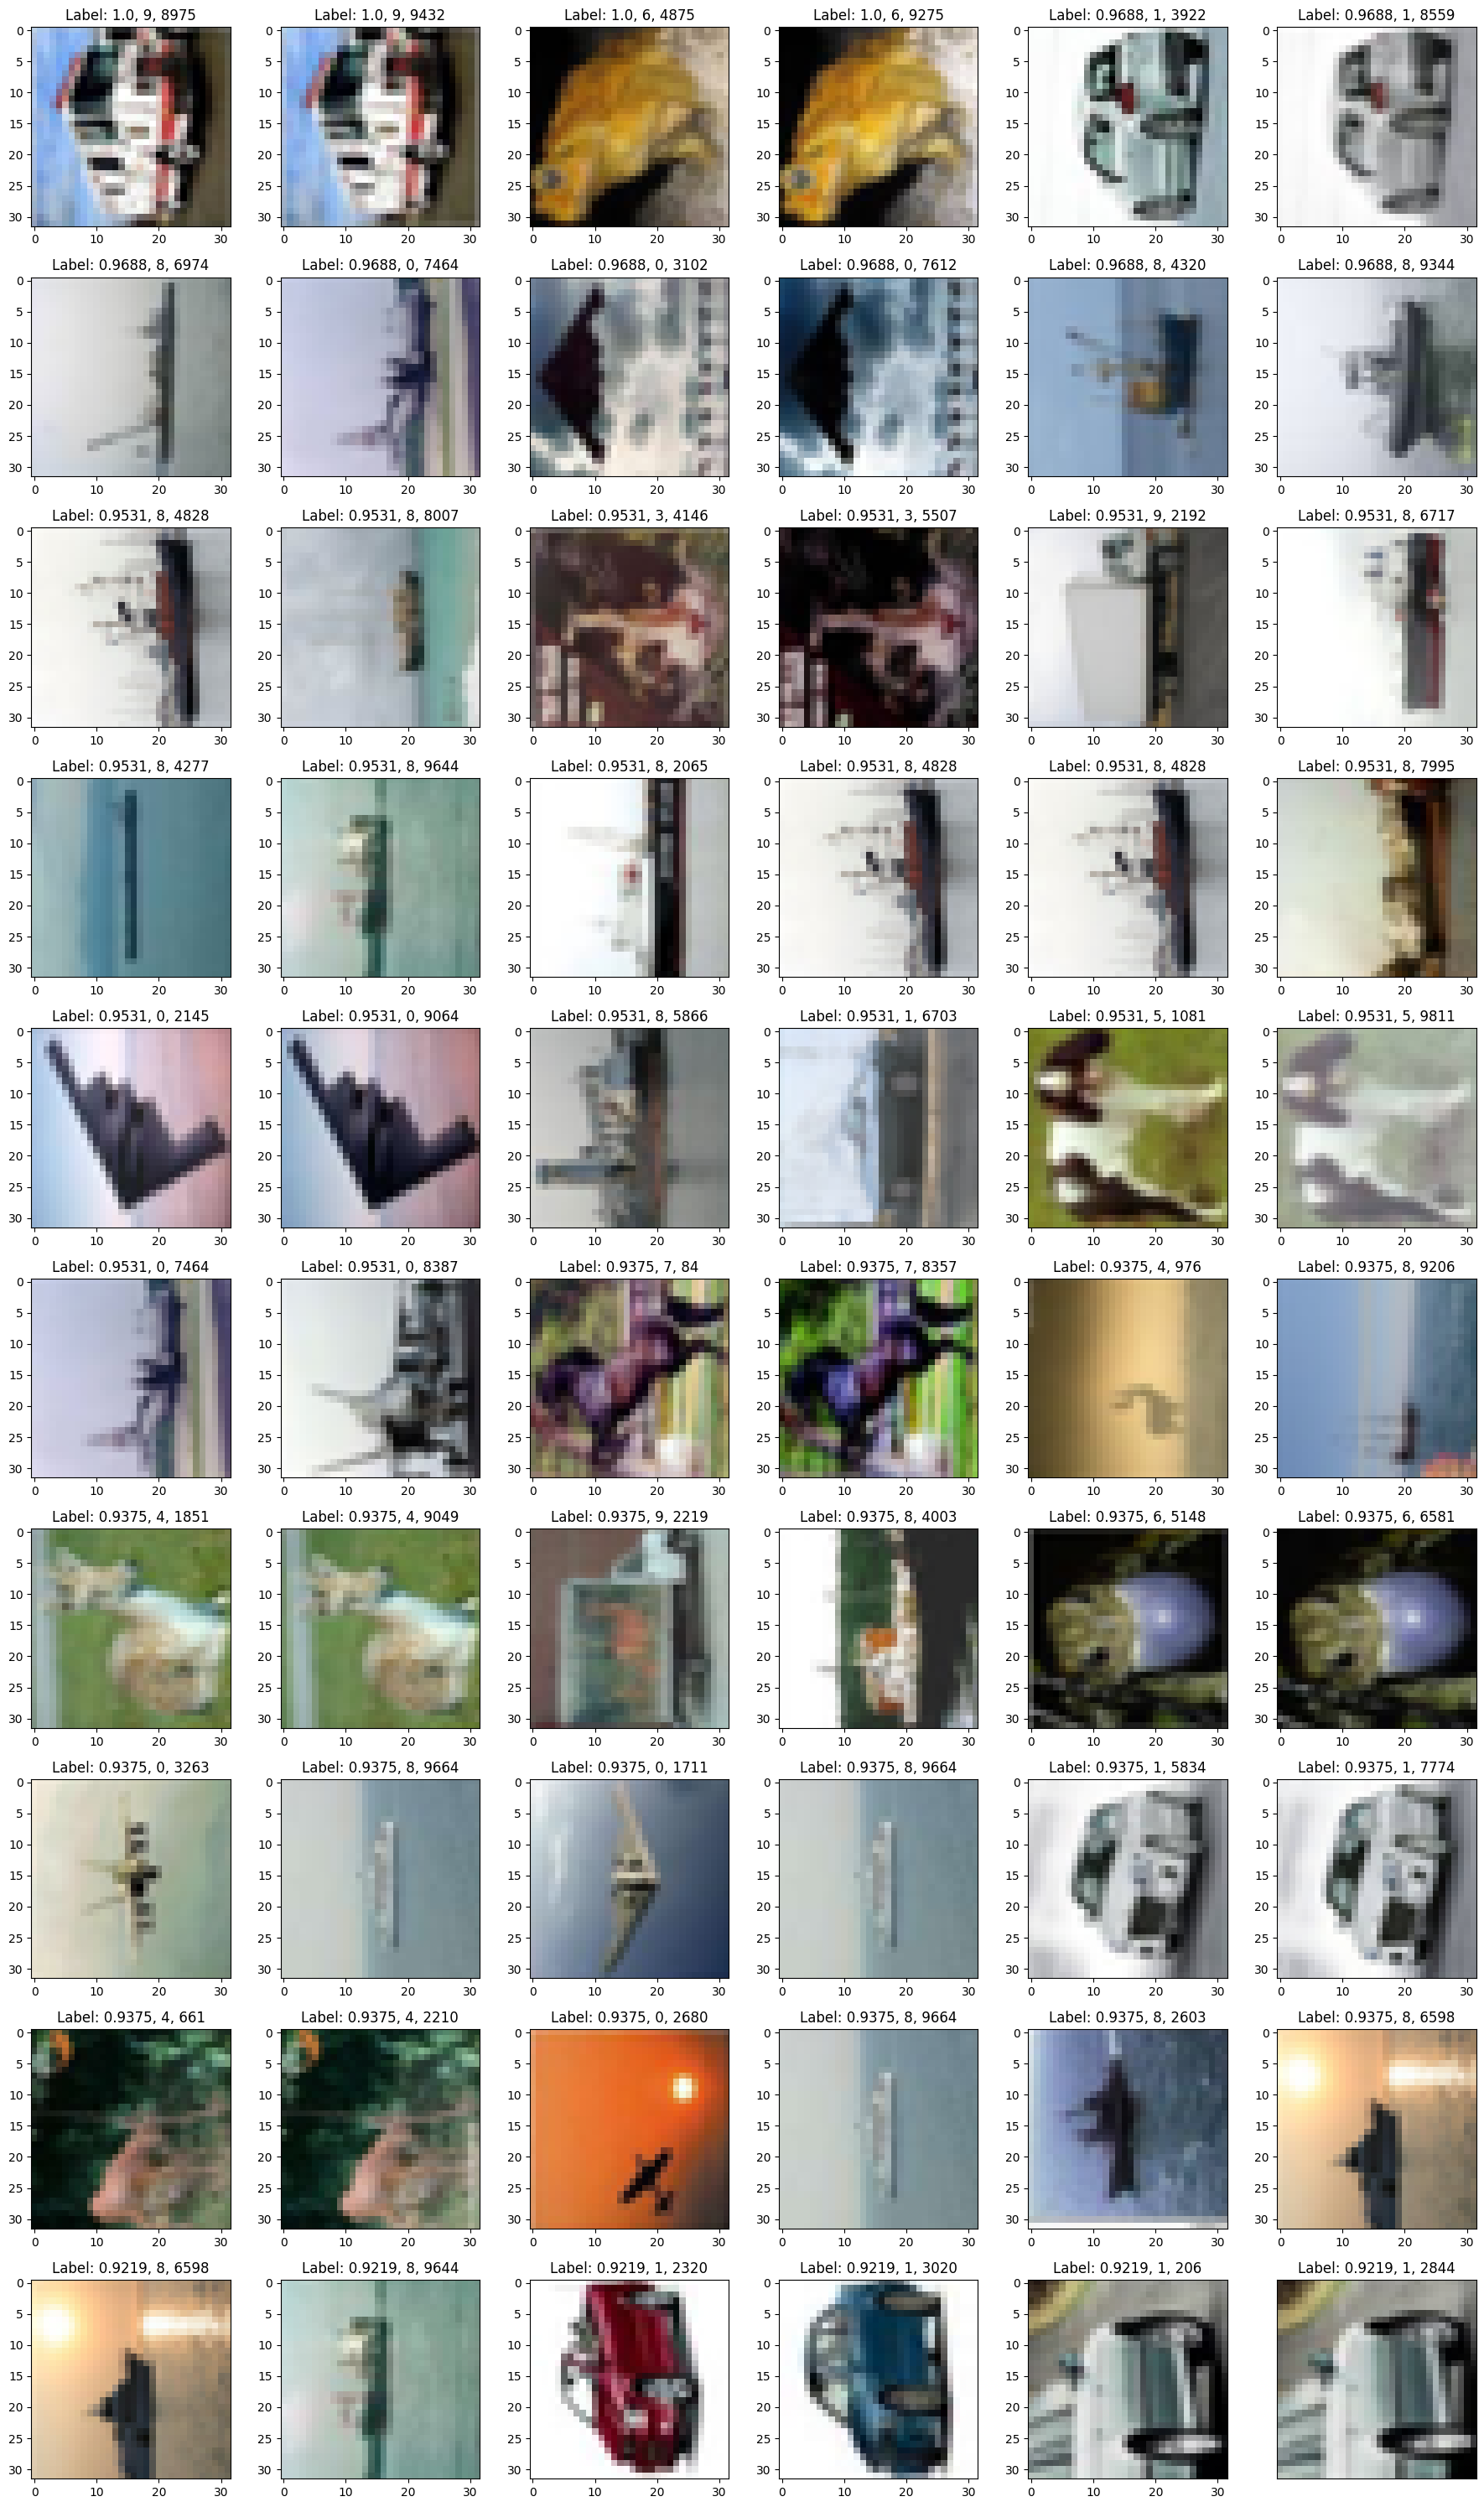

In [88]:
num_row = 10
num_col = 6

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 2):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[duplicates[i//2 + idx_start][0]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels[duplicates[i//2 + idx_start][0]]}, {duplicates[i//2 + idx_start][0]}""")

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(images[duplicates[i//2 + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels[duplicates[i//2 + idx_start][1]]}, {duplicates[i//2 + idx_start][1]}""")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

#### Calculate MAP

In [86]:
from torcheval.metrics.functional import multiclass_auprc

In [96]:
print( len(duplicates) )

withoutLastElements = 7800#577600

sumTrueDuplicates = 0
# same classes vs total 
for i in range( len(duplicates) - withoutLastElements ):
    #print(labels[duplicates[i][0]])
    #print(labels[duplicates[i][1]])
    if labels[duplicates[i][0]] == labels[duplicates[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates) - withoutLastElements )
print(acc)

7996
True duplicates:  104
All duplicates:  196
0.5306122448979592


In [328]:
#To write

In [332]:
#https://stackoverflow.com/questions/68610362/how-are-detect-and-compute-different-from-detectandcompute
#https://stackoverflow.com/questions/55313610/importerror-libgl-so-1-cannot-open-shared-object-file-no-such-file-or-directo
#https://ieeexplore.ieee.org/document/7043862
#https://pyimagesearch.com/2021/03/22/opencv-template-matching-cv2-matchtemplate/
#https://stackoverflow.com/questions/71514124/find-near-duplicate-and-faked-images
#https://neptune.ai/blog/object-detection-algorithms-and-libraries
#https://charlielehman.github.io/post/weak-segmentation-cifar10/

#### Metody Porównywania


In [419]:
# https://medium.com/@datamonsters/a-quick-overview-of-methods-to-measure-the-similarity-between-images-f907166694ee
# pshr method to compare
# https://www.linkedin.com/pulse/how-can-we-compare-two-images-python-pranav-kshirsagar-sxnkf
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
# frechet distance ???

### LSH with SHASH

In [447]:
from typing import List, Dict, Tuple

class LSH3:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):  # shingels
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0;
        for image in images:
            signature = calculate_signature_np_only_edges(image.T, self.hash_size)
            self.signatures[idx] = np.packbits(signature.astype(np.uint8))
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates
            
    

In [451]:
import time

start = time.time()

lsh = LSH3(16, 16)
shingels = lsh.compute_hash(images)
pairs = lsh.compute_candidate()
duplicates = lsh.check_candidate(pairs,0.70)

end = time.time()
print( "time: ", end - start )

time:  7.286614894866943


In [452]:
from torcheval.metrics.functional import multiclass_auprc

In [458]:
print( len(duplicates) )

withoutLastElements = 200

sumTrueDuplicates = 0
# same classes vs total 
for i in range( len(duplicates) - withoutLastElements ):
    #print(labels[duplicates[i][0]])
    #print(labels[duplicates[i][1]])
    if labels[duplicates[i][0]] == labels[duplicates[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates) - withoutLastElements )
print(acc)

483
True duplicates:  123
All duplicates:  283
0.43462897526501765


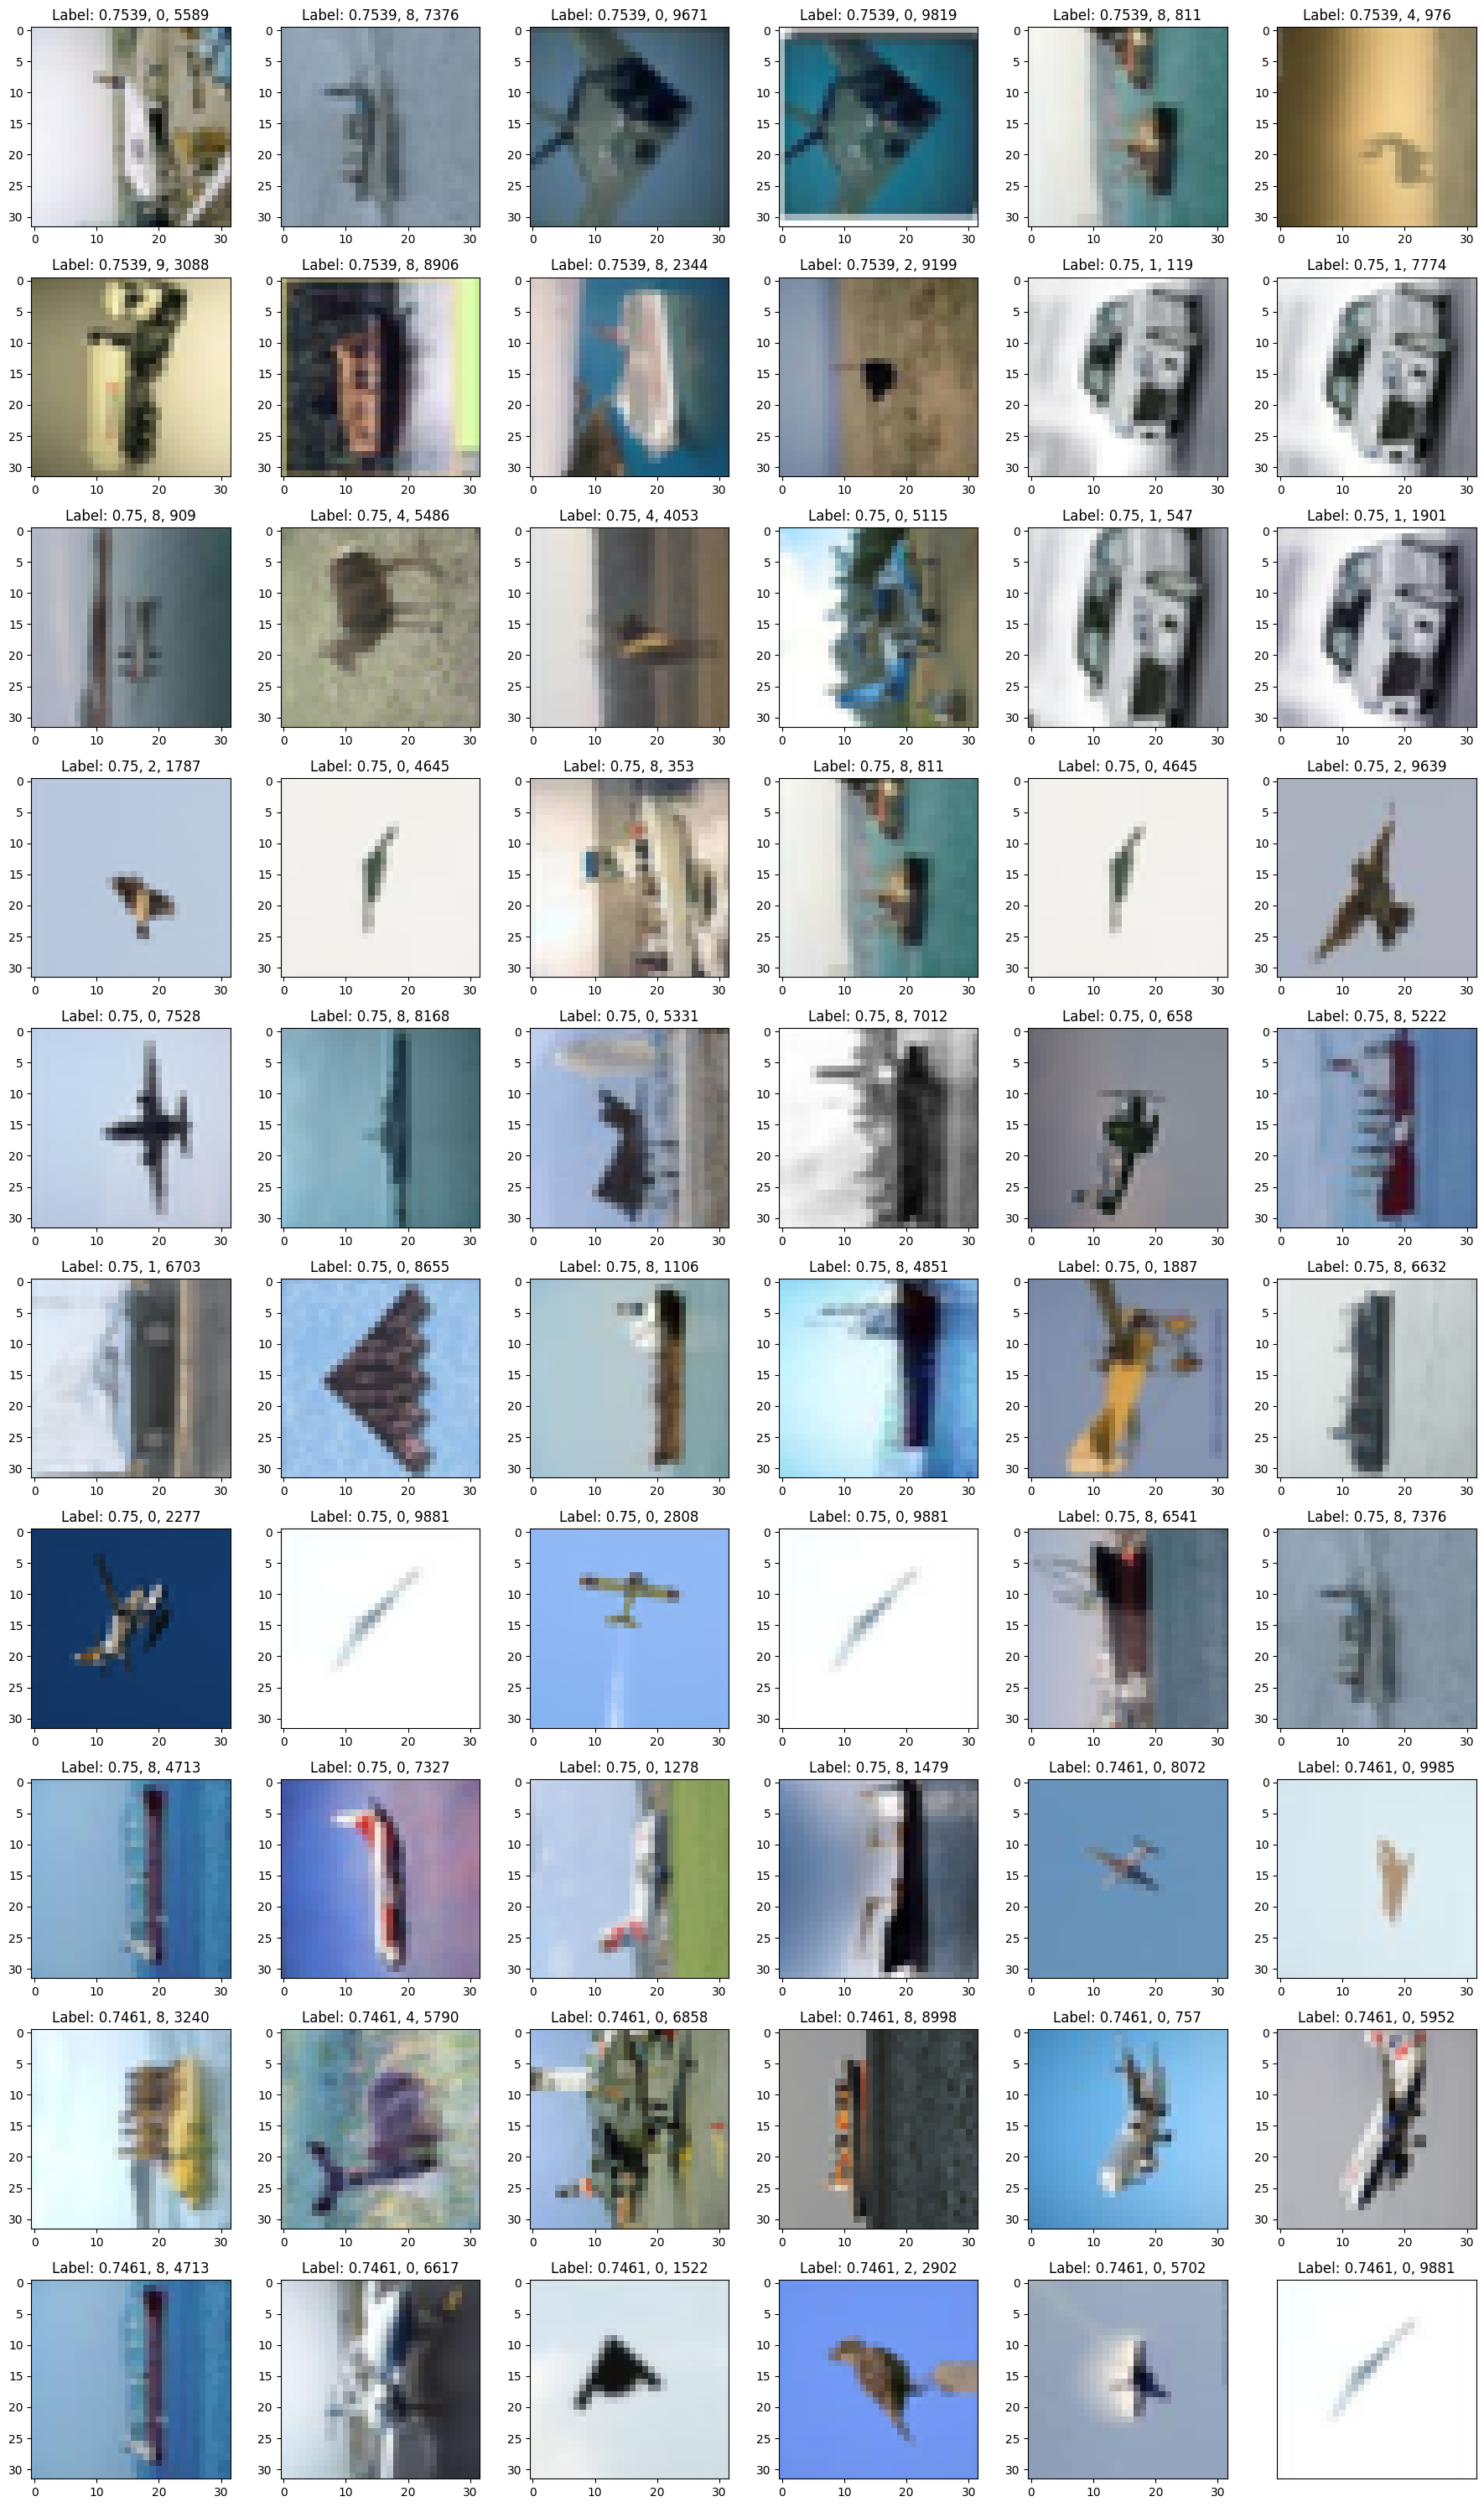

In [460]:
num_row = 10
num_col = 6

idx_start = 60;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 2):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[duplicates[i//2 + idx_start][0]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels[duplicates[i//2 + idx_start][0]]}, {duplicates[i//2 + idx_start][0]}""")

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(images[duplicates[i//2 + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels[duplicates[i//2 + idx_start][1]]}, {duplicates[i//2 + idx_start][1]}""")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

In [461]:
## double verification....